In [40]:
import os
import copy
import salem
from oggm import cfg, utils, workflow, graphics, tasks
from oggm.core.flowline import equilibrium_stop_criterion, FileModel
import oggm
import plot_gcm
from functools import partial
import random
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import plot_gcm
import importlib
import dask
from dask.diagnostics import ProgressBar

from cycler import cycler
import matplotlib as mpl
from matplotlib import colors
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['font.size'] =30
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['axes.labelweight'] = 'medium'
mpl.rcParams['legend.fontsize'] = 20 #30
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['xtick.major.pad']='8'
mpl.rcParams['ytick.major.pad']='8'
mpl.rcParams["figure.figsize"] = (15,10)

dask.config.set({"array.slicing.split_large_chunks": False})

# create cmap
color_list=[colors.to_rgb('#'+c) for c in ["001219","003946","005f73","0a9396","4fb3aa","94d2bd","e9d8a6","ecba53","ee9b00","dc8101","bb3e03","8d210c","5e0314"]]
gcm_cmap = cmap = mpl.colors.ListedColormap(color_list)
custom_cycler = cycler(color=gcm_cmap.colors)

### Read results from first run

In [11]:
READING_DIR='out/run_CMIP6_geod'

# read geodetic output
with ProgressBar():
    p = os.path.join(READING_DIR,'*_equilibrium.nc')
    all_ds = xr.open_mfdataset(p, parallel=True)

# original output    
all_ds = all_ds.assign_coords({"region": all_ds.rgi_id.str[6:8]}).equilibrium

# interpolated dataset
merge_ds = xr.open_dataset('merge_ds.nc')
merge_ds = merge_ds.sel(rgi_id=merge_ds.region=='03')

# keep only not "too-hot" models
ex_2_hot=['FGOALS-f3-L', 'BCC-CSM2-MR', 'MRI-ESM2-0', 'MPI-ESM1-2-HR', 'ACCESS-CM2', 'MIROC6', 'CESM2', 'GISS-E2-2-H','CRU']
all_ds = all_ds.sel(gcm=ex_2_hot)
merge_ds = merge_ds.sel(gcm=ex_2_hot)

[########################################] | 100% Completed |  0.4s


In [12]:
all_ds

<xarray.DataArray 'equilibrium' (rgi_id: 205699, gcm: 9, year: 154)>
dask.array<getitem, shape=(205699, 9, 154), dtype=float64, chunksize=(52044, 9, 154), chunktype=numpy.ndarray>
Coordinates:
  * rgi_id   (rgi_id) object 'RGI60-01.00001' ... 'RGI60-18.03537'
  * gcm      (gcm) object 'FGOALS-f3-L' 'BCC-CSM2-MR' ... 'GISS-E2-2-H' 'CRU'
  * year     (year) int64 1866 1867 1868 1869 1870 ... 2015 2016 2017 2018 2019
    region   (rgi_id) object '01' '01' '01' '01' '01' ... '18' '18' '18' '18'
Attributes:
    description:  total glacier volume of equilibrium glacier
    units:        km 3

### Find out which galciers failed for which gcms

In [17]:
failed=pd.DataFrame(index=all_ds.rgi_id)
for gcm in all_ds.gcm:
    failed.loc[:,str(gcm.values)]=np.array(all_ds.sel(gcm=gcm).dropna(dim='year', how='all').isnull().to_pandas().sum(axis=1).clip(0,1).values)
failed = failed[failed.sum(axis=1)!=0]

In [18]:
failed

,FGOALS-f3-L,BCC-CSM2-MR,MRI-ESM2-0,MPI-ESM1-2-HR,ACCESS-CM2,MIROC6,CESM2,GISS-E2-2-H,CRU
RGI60-01.00060,1,0,1,1,1,1,0,1,1
RGI60-01.00198,1,1,1,1,1,1,1,1,1
RGI60-01.00268,1,1,1,1,1,1,0,1,1
RGI60-01.00294,1,1,1,1,1,1,1,1,1
RGI60-01.00327,1,0,0,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...
RGI60-18.01557,1,1,1,1,1,0,1,1,1
RGI60-18.01779,1,0,0,1,1,0,0,0,1
RGI60-18.01831,1,1,1,1,1,0,1,1,1
RGI60-18.01993,1,0,0,0,0,0,0,0,0


We save this table to know which galcier for which gcm we need to rerun backwards

In [82]:
failed.drop('region', axis=1).to_csv('run_reverse.txt')

Number of glaciers that failed in each region:

In [20]:
failed.loc[:,'region']=failed.index.str[6:8]
failed.region.value_counts().sort_index()

01     498
02     387
03     571
04    1351
05    2970
06      46
07     752
08     281
09     341
10     602
11      12
12      19
13    2040
14     815
15      46
16      67
17     436
18      12
Name: region, dtype: int64

Number of gcms failed: 

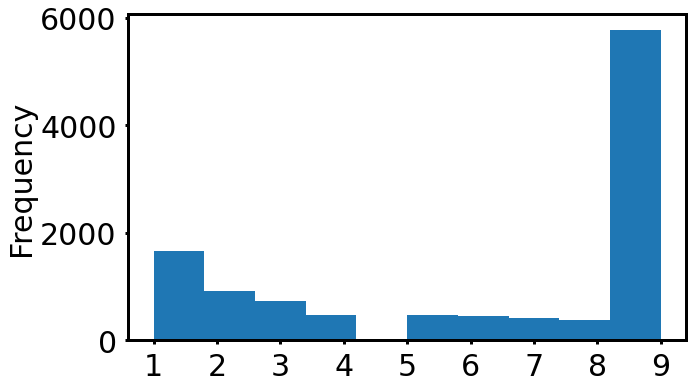

In [54]:
failed.drop('region',axis=1).sum(axis=1).plot.hist(figsize=(10,6))
plt.xticks(range(1,10));

In most cases all gcms or just a small number of gcms failed. 

In [95]:
f_ds = xr.concat([all_ds.sel(gcm=gcm).drop_sel(rgi_id=all_ds.sel(gcm=gcm).dropna(dim='year',how='all').dropna(dim='rgi_id').rgi_id) for gcm in all_ds.gcm], dim='gcm')

In [98]:
f_ds

,Array,Chunk
Bytes,118.92 MiB,3.49 MiB
Shape,"(9, 11246, 154)","(1, 2970, 154)"
Count,2279 Tasks,279 Chunks
Type,float64,numpy.ndarray


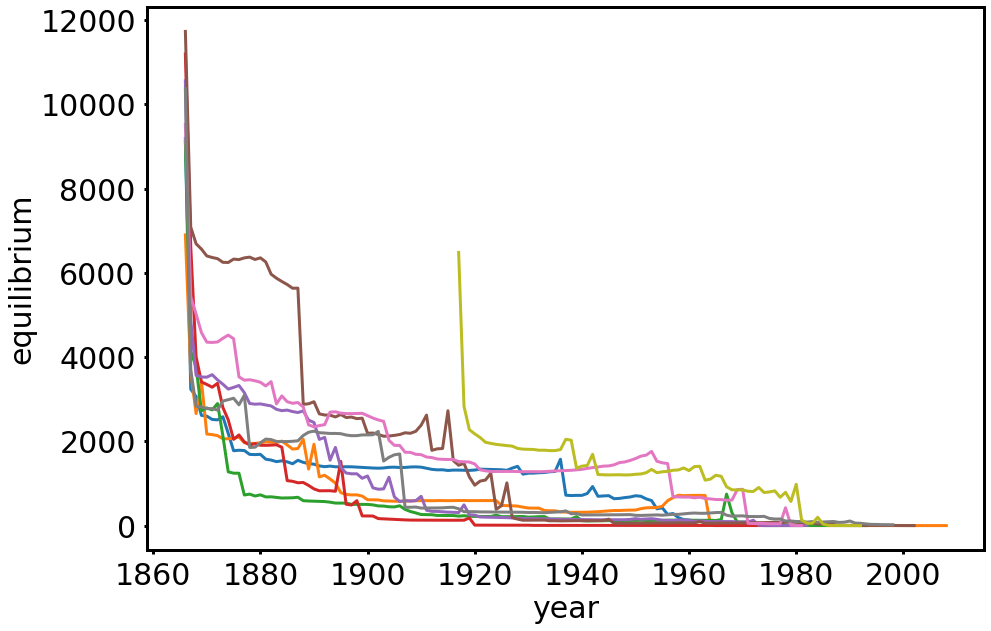

In [99]:
f_ds.sum(dim='rgi_id', min_count=1).plot(hue='gcm',add_legend=False);

In [171]:
f_ds = f_ds.assign_coords({"region": f_ds.rgi_id.str[6:8]})

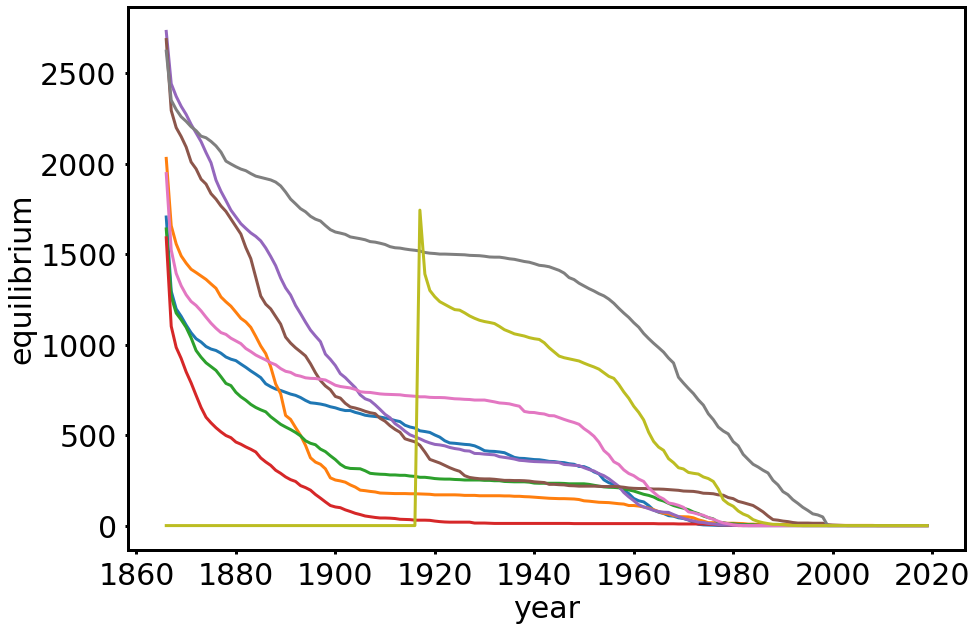

In [217]:
f_ds.count(dim='rgi_id').plot(hue='gcm', add_legend=False);

## Rerun the the failed glaciers from reverse
Originally we started with a 2000/5000 year long run for the first equilibrium year 1866 (or 1917). In a second run, we repeat the simulaion, but reverse the years. we started to search first for an equilibrium of the last year. 
First, we need to merge the output per region: 

In [202]:
READING_DIR='out/run_CMIP6_geod_reverse'
for i in range(12,19):
    REGION = str(i).zfill(2)
    read_dir = os.path.join(READING_DIR, 'region_'+REGION,'*.nc')
    print(read_dir)
    with ProgressBar():
        ds = xr.open_mfdataset(read_dir, parallel=True, concat_dim='rgi_id', combine='nested')
        p = os.path.join(READING_DIR, REGION+'_equilibrium_reverse.nc')
        #os.remove(p)
        ds.to_netcdf(p)
        print('region '+REGION+' DONE')

out/run_CMIP6_geod_reverse/region_12/*.nc
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
region 12 DONE
out/run_CMIP6_geod_reverse/region_13/*.nc
[########################################] | 100% Completed | 26.4s
[########################################] | 100% Completed | 28.0s
region 13 DONE
out/run_CMIP6_geod_reverse/region_14/*.nc
[########################################] | 100% Completed | 10.8s
[########################################] | 100% Completed | 10.9s
region 14 DONE
out/run_CMIP6_geod_reverse/region_15/*.nc
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.5s
region 15 DONE
out/run_CMIP6_geod_reverse/region_16/*.nc
[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  0.7s
region 16 DONE
out/run_CMIP6_geod_reverse/region_1

In [219]:
# read geodetic output
with ProgressBar():
    p = os.path.join(READING_DIR,'*_equilibrium_reverse.nc')
    r_ds = xr.open_mfdataset(p, parallel=True).equilibrium

[########################################] | 100% Completed |  0.2s


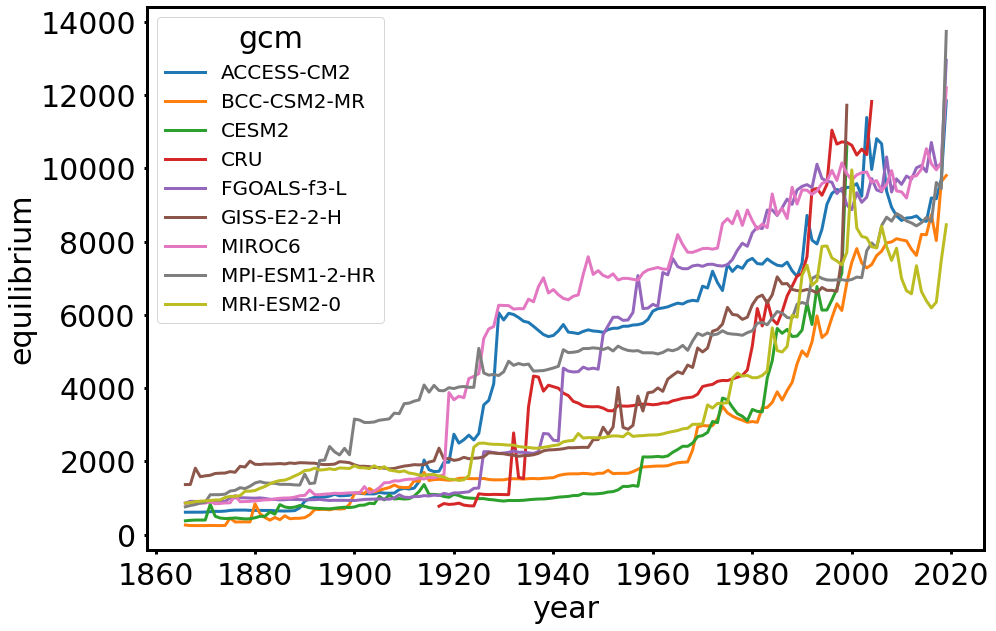

In [221]:
r_ds.sum(dim='rgi_id',min_count=1).plot(hue='gcm');

In [243]:
f_ds

,Array,Chunk
Bytes,118.92 MiB,3.49 MiB
Shape,"(9, 11246, 154)","(1, 2970, 154)"
Count,2279 Tasks,279 Chunks
Type,float64,numpy.ndarray


In [251]:
xr.merge([f_ds,r_ds], compat='no_conflicts')#.sum(dim='rgi_id', min_count=1).plot(hue='gcm')

MergeError: conflicting values for variable 'equilibrium' on objects to be combined. You can skip this check by specifying compat='override'.

In [311]:
ds = r_ds.combine_first(f_ds)


In [330]:
ds

,Array,Chunk
Bytes,118.92 MiB,3.49 MiB
Shape,"(11246, 9, 154)","(2970, 1, 154)"
Count,4440 Tasks,279 Chunks
Type,float64,numpy.ndarray


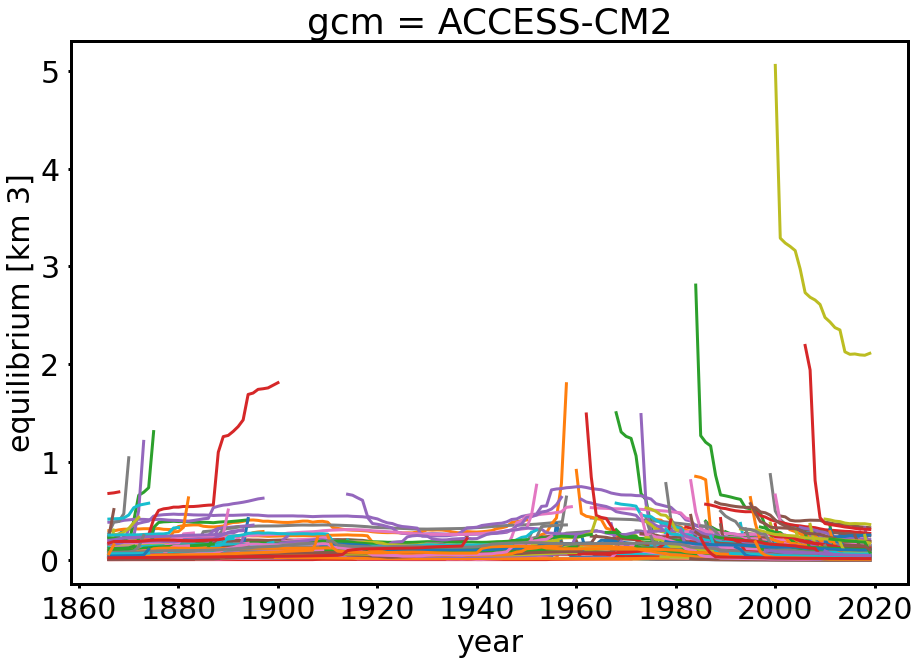

In [329]:
ds.sel(rgi_id=ds.region=='14', gcm=ds.gcm[0]).plot(hue='rgi_id',add_legend=False);